In [1]:
"""1. 필요한 Module import"""

import numpy as np  
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import torch
from torch import nn
from torch.autograd import Variable
import random
import time
from torch.utils.data import Dataset
from datetime import timedelta
from torch.utils.data import DataLoader
from collections import defaultdict
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

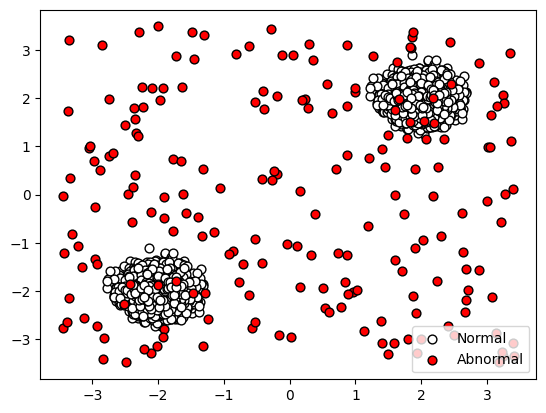

In [89]:
"""데이터 1. Custom 데이터"""


# Random 수치 설정
random_state = np.random.RandomState(42)

# 전체 데이터 수와 이상치 비율 설정
num_made_data = 10000
test_made_rate = 0.2
anomal_made_rate = 0.02

# X_made_train 설정 
X_made_train = 0.2 * random_state.randn(num_made_data, 2)
X_made_train = np.r_[X_made_train+2, X_made_train-2]
X_made_train = pd.DataFrame(X_made_train, columns = ['x1', 'x2'])


# X_made_test 설정
X_made_test = 0.2 * random_state.randn(int(num_made_data * test_made_rate), 2)
X_made_test = np.r_[X_made_test+2, X_made_test-2]
X_made_test = pd.DataFrame(X_made_test, columns = ['x1', 'x2'])

# 이상치 데이터 생성
abnormal_made_data = random_state.uniform(low=-3.5, high=3.5, size=(int(num_made_data * anomal_made_rate), 2))
abnormal_made_data = pd.DataFrame(abnormal_made_data, columns = ['x1', 'x2'])

# Train과 이상치 데이터 시각화
plt.scatter(X_made_train.x1, X_made_train.x2, c='white', s=10*4, edgecolor='k', label='Normal')
plt.scatter(abnormal_made_data.x1, abnormal_made_data.x2, c='red', s=10*4, edgecolor='k', label='Abnormal')

plt.legend(loc='lower right')
plt.show()

In [90]:
# 이상치, 정상데이터에 라벨 추가한 후, Test_data에 이상치 섞어주기

X_made_train['label'] = 0
X_made_test['label'] = 0
abnormal_made_data['label'] = 1

X_made_test = pd.concat([X_made_test, abnormal_made_data], axis = 0)
X_made_test = X_made_test.sample(frac=1)

In [59]:
"""데이터 2. MNIST 데이터에 임의로 이상치 만들어서 넣어주기"""
mnist = fetch_openml('mnist_784')

In [60]:
# 비율 설정
rate_mnist = 0.1
test_mnist_rate = 0.2
anomal_mnisit_rate = 0.01


# Train, Test 설정
X_mnist= mnist['data'][:int(len(mnist['data'])*rate_mnist)]

# Train, Test 비율 설정
X_mnist_train, X_mnist_test = X_mnist[:int(len(X_mnist)*(1-test_mnist_rate))], X_mnist[int(len(X_mnist)*(1-test_mnist_rate)):]
mnist_col = X_mnist_train.columns

# 이상치 데이터 비율 설정
abnormal_mnist = mnist['data'][len(X_mnist):len(X_mnist)+int(len(X_mnist)*(anomal_mnisit_rate))] 

In [61]:
# 기존 Mnist와는 아예 다른 이미지 생성

def make_fake_img(n_fake_img):
    img_size = 28
    n_fake_img = n_fake_img
    fake_img  = []
    for i in range(n_fake_img):
        fake_img.append(np.random.randn(img_size * img_size).reshape(1, img_size, img_size) )
 
    fake_img = torch.FloatTensor(fake_img)
    fake_img = fake_img.view(n_fake_img, img_size * img_size)
 
    return fake_img

random_mnist_anormal_or = make_fake_img(len(abnormal_mnist))
random_mnist_anormal = pd.DataFrame(random_mnist_anormal_or)
random_mnist_anormal.columns = mnist_col

In [62]:
# Mnist 데이터 set에서의 anomal 생성

for i in range(len(abnormal_mnist)):
    row = abnormal_mnist.iloc[i]
    for i in range(len(row)-1):
        row[i+1] = min(255, row[i+1]+random.randint(100,200))

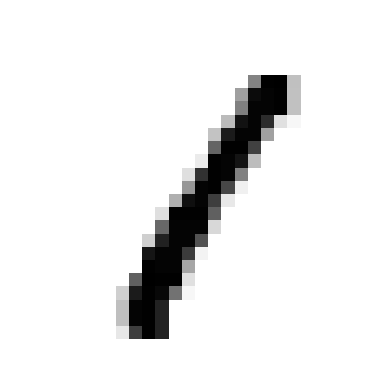

In [63]:
# 정상데이터 시각화

digit = X_mnist_train.iloc[3].to_numpy()
digit_image = digit.reshape(28, 28)

plt.imshow(digit_image, cmap="binary")
plt.axis("off")
plt.show()

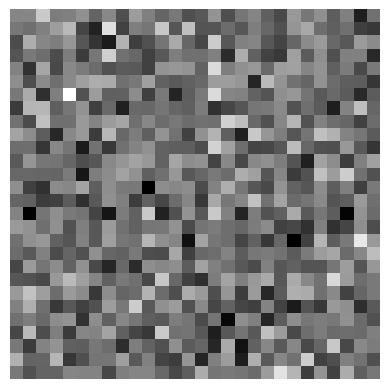

In [64]:
# 랜덤하게 생성한 Abnormal 시각화

digit = random_mnist_anormal.iloc[0].to_numpy()
digit_image = digit.reshape(28, 28)

plt.imshow(digit_image, cmap="binary")
plt.axis("off")
plt.show()

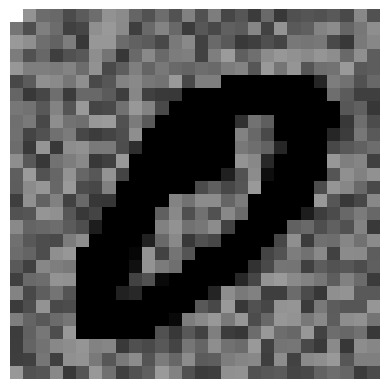

In [65]:
# Mnist 데이터 set에서 생성한 anomal 데이터 시각화

digit = abnormal_mnist.iloc[3].to_numpy()
digit_image = digit.reshape(28, 28)

plt.imshow(digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [66]:
# 정상, 이상치 데이터 라벨링. Anomal 데이터 합쳐준 후, Train에는 정상 데이터만, Test에는 정상 + 이상 데이터 함께 구성

X_mnist_train['label'] = 0
Anomal_data_mnist = pd.concat([abnormal_mnist, random_mnist_anormal], axis = 0)
Anomal_data_mnist['label'] = 1
X_mnist_test['label'] = 0
X_mnist_test = pd.concat([X_mnist_test, Anomal_data_mnist], axis = 0, ignore_index=True)
X_mnist_test = X_mnist_test.sample(frac=1)

In [67]:
X_mnist_train.shape

(5600, 785)

In [91]:
# 직접 만든 데이터이므로, Cumstom data 설정 해주는 함수.

class Mnist_Loader(Dataset):
    def __init__(self):
        super(Mnist_Loader, self).__init__()
        self.dataset = ''
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        row = row.drop(labels={'label'})
        data = torch.from_numpy(np.array(row)/255).float()
        return data
    
class custom_Loader(Dataset):
    def __init__(self):
        super(custom_Loader, self).__init__()
        self.dataset = ''

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        row = row.drop(labels={'label'})
        data = torch.from_numpy(np.array(row)).float()
        return data

In [92]:
# MNIST 데이터셋 구성 
 
class Mnist_Train_Loader(Mnist_Loader):
    def __init__(self):
        super(Mnist_Train_Loader, self).__init__()
        self.dataset = X_mnist_train
        
class Mnist_Test_Loader(Mnist_Loader):
    def __init__(self):
        super(Mnist_Test_Loader, self).__init__()
        self.dataset = X_mnist_test
        
trainset_mnist = Mnist_Train_Loader()
testset_mnist = Mnist_Test_Loader()

train_mnist = DataLoader(
            trainset_mnist,
            batch_size=32,
            shuffle=True
        )

test_mnist = DataLoader(
            testset_mnist,
            batch_size=32,
            shuffle=False
        )

In [93]:
# Custom 데이터셋 구성

class made_Train_Loader(custom_Loader):
    def __init__(self):
        super(made_Train_Loader, self).__init__()
        self.dataset = X_made_train
        
class made_Test_Loader(custom_Loader):
    def __init__(self):
        super(made_Test_Loader, self).__init__()
        self.dataset = X_made_test
        
trainset_made = made_Train_Loader()
testset_made = made_Test_Loader()

train_made = DataLoader(
            trainset_made,
            batch_size=32,
            shuffle=True
        )

test_made = DataLoader(
            testset_made,
            batch_size=32,
            shuffle=False
        )

In [94]:
"""Original Autoencoder: Mnist"""

class Mnist_encoder(nn.Module):
    def __init__(self):
        super(Mnist_encoder, self).__init__()
        self.Mnist_encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(), 
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(), 
            nn.Linear(32, 2),
            nn.BatchNorm1d(2),
            nn.ReLU()
        )
 
    def forward(self, x):
        x = self.Mnist_encoder(x)
        return x
 
 
class Mnist_decoder(nn.Module):
    def __init__(self):
        super(Mnist_decoder, self).__init__()
        self.Mnist_decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(), 
            nn.Linear(128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(), 
            nn.Linear(512, 28*28),
            nn.BatchNorm1d(28*28),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        x = self.Mnist_decoder(x)
        return x


In [95]:
"""Original Autoencoder: custom"""

class made_encoder(nn.Module):
    def __init__(self):
        super(made_encoder, self).__init__()
        self.made_encoder = nn.Sequential(
            nn.Linear(2, 1),
            nn.BatchNorm1d(1),
            nn.ReLU()
        )
 
    def forward(self, x):
        x = self.made_encoder(x)
        return x
 
 
class made_decoder(nn.Module):
    def __init__(self):
        super(made_decoder, self).__init__()
        self.made_decoder = nn.Sequential(
            nn.Linear(1, 2),
            nn.BatchNorm1d(2),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        x = self.made_decoder(x)
        return x


In [96]:
# GPU 할당
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 인코더 디코더 설정
Mnist_encoder = Mnist_encoder().to(device)
Mnist_decoder = Mnist_decoder().to(device)

made_encoder = made_encoder().to(device)
made_decoder = made_decoder().to(device)



# Loss 값도 다양하게 해볼 예정
learning_rate = 0.001
num_epochs = 50
criterion = nn.MSELoss()
w_d = 0.0001
metrics = defaultdict(list)


Mnist_encoder_optimizer = torch.optim.Adam(Mnist_encoder.parameters(), lr=learning_rate, weight_decay=w_d)
Mnist_decoder_optimizer = torch.optim.Adam(Mnist_decoder.parameters(), lr=learning_rate, weight_decay=w_d)

made_encoder_optimizer = torch.optim.Adam(made_encoder.parameters(), lr=learning_rate, weight_decay=w_d)
made_decoder_optimizer = torch.optim.Adam(made_decoder.parameters(), lr=learning_rate, weight_decay=w_d)

In [73]:
Mnist_encoder.train()
Mnist_decoder.train()

start = time.time()
print('-----------------Original Autoencoder: MNIST----------------')
for epoch in range(num_epochs):
    ep_start = time.time()
    # running_loss = 0.0
    
    for bx, (data) in enumerate(train_mnist):
        img = data
        img = img.view(img.size(0), -1)
        img = Variable(img)

        latent_z = Mnist_encoder(img.to(device))
        output = Mnist_decoder(latent_z.to(device))

        loss = criterion(output, img.to(device))
 
        Mnist_encoder_optimizer.zero_grad()
        Mnist_decoder_optimizer.zero_grad()
        loss.backward()
        Mnist_encoder_optimizer.step()
        Mnist_decoder_optimizer.step()
        # running_loss += loss.item()
        
    # epoch_loss = running_loss/len(trainset_mnist)
    metrics['train_loss'].append(loss.data)
    ep_end = time.time()
    print('-------------------------------------------------------------')
    print('epoch [{}/{}], loss:{:.4f}' .format(epoch + 1, num_epochs, float(loss.data) ))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-------------------------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

-----------------Original Autoencoder: MNIST----------------
-------------------------------------------------------------
epoch [1/50], loss:0.1939
Epoch Complete in 0:00:06.530483
-------------------------------------------------------------
epoch [2/50], loss:0.1731
Epoch Complete in 0:00:06.346594
-------------------------------------------------------------
epoch [3/50], loss:0.1541
Epoch Complete in 0:00:06.445392
-------------------------------------------------------------
epoch [4/50], loss:0.1380
Epoch Complete in 0:00:06.342739
-------------------------------------------------------------
epoch [5/50], loss:0.1201
Epoch Complete in 0:00:06.466405
-------------------------------------------------------------
epoch [6/50], loss:0.1147
Epoch Complete in 0:00:06.444628
-------------------------------------------------------------
epoch [7/50], loss:0.1092
Epoch Complete in 0:00:06.331302
-------------------------------------------------------------
epoch [8/50], loss:0.1012
Epoc

In [97]:
made_encoder.train()
made_decoder.train()

start = time.time()
print('-----------------Original Autoencoder: Custom----------------')
for epoch in range(num_epochs):
    ep_start = time.time()
    # running_loss = 0.0
    
    for bx, (data) in enumerate(train_made):
        img = data # label은 가져오지 않는다.
        img = img.view(img.size(0), -1)
        img = Variable(img)

        latent_z = made_encoder(img.to(device))
        output = made_decoder(latent_z.to(device))

        loss = criterion(output, img.to(device))
 
        made_encoder_optimizer.zero_grad()
        made_decoder_optimizer.zero_grad()
        loss.backward()
        made_encoder_optimizer.step()
        made_decoder_optimizer.step()
        # running_loss += loss.item()
        
    # epoch_loss = running_loss/len(trainset_mnist)
    metrics['train_loss'].append(loss.data)
    ep_end = time.time()
    print('-------------------------------------------------------------')
    print('epoch [{}/{}], loss:{:.4f}' .format(epoch + 1, num_epochs, float(loss.data) ))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-------------------------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

-----------------Original Autoencoder: Custom----------------
-------------------------------------------------------------
epoch [1/50], loss:3.5089
Epoch Complete in 0:00:09.714600
-------------------------------------------------------------
epoch [2/50], loss:3.1715
Epoch Complete in 0:00:09.726812
-------------------------------------------------------------
epoch [3/50], loss:2.6908
Epoch Complete in 0:00:09.572950
-------------------------------------------------------------
epoch [4/50], loss:2.8316
Epoch Complete in 0:00:09.984212
-------------------------------------------------------------
epoch [5/50], loss:3.5229
Epoch Complete in 0:00:09.942750
-------------------------------------------------------------
epoch [6/50], loss:2.9712
Epoch Complete in 0:00:09.697797
-------------------------------------------------------------
epoch [7/50], loss:2.4213
Epoch Complete in 0:00:09.583259
-------------------------------------------------------------
epoch [8/50], loss:2.6202
Epo

Text(0, 0.5, 'Training Loss')

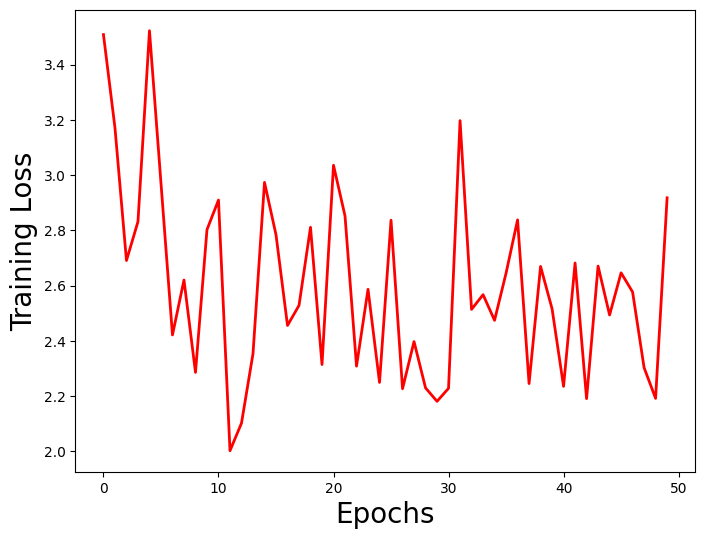

In [98]:
# Loss graph plot

A = metrics['train_loss']
metrics_list = []
for i in range(len(A)):
    metrics_list.append(A[i].to('cpu'))
    
_, axs = plt.subplots(1 , 1 , figsize=(8,6) )

axs.plot(metrics_list , 'r', linewidth = 2)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Training Loss', fontsize=20)

In [75]:
# Mnist data 평가

Mnist_encoder.eval()
Mnist_decoder.eval()

loss_dist = []
pred_dist = []
correct=0

for i in range(len(X_mnist_test)):
    data = torch.from_numpy(np.array(X_mnist_test.iloc[i][:-1])).float().unsqueeze(0)
    latent_z = Mnist_encoder(data.to(device))
    output = Mnist_decoder(latent_z.to(device))
    loss = criterion(data.to(device), output)
    loss_dist.append(loss.item())

In [99]:
# custom data 평가

made_encoder.eval()
made_decoder.eval()

loss_dist = []
pred_dist = []
correct=0
# anom = X_mnist_test
# for bx, data in enumerate(test_made):
for i in range(len(X_made_test)):
    data = torch.from_numpy(np.array(X_made_test.iloc[i][0:2])).float().unsqueeze(0)
    latent_z = made_encoder(data.to(device))
    output = made_decoder(latent_z.to(device))
    loss = criterion(data.to(device), output)
    pred_dist.append(data.cpu().numpy().flatten())
    loss_dist.append(loss.item())

In [100]:
def plot_ROC(y_test, recon_error_test):    
    fpr, tpr, thresholds = roc_curve(y_test, recon_error_test)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig('ROC',dpi=1200)
    plt.show()
    print(f'AUC:{roc_auc}')

Cumstom 용도 

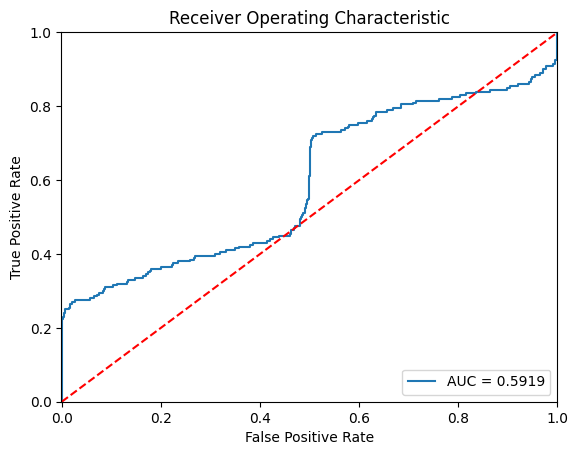

AUC:0.5919025


In [101]:
plot_ROC(X_made_test['label'], loss_dist)

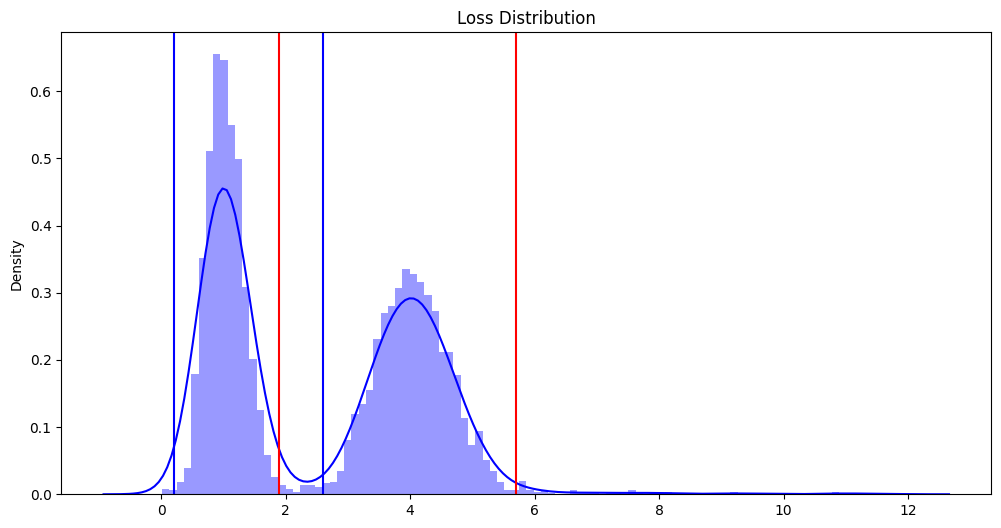

In [102]:
# Custom data 용

lower_threshold1 = 0.2
upper_threshold1 = 1.9
lower_threshold2 = 2.6
upper_threshold2 = 5.7

plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(loss_dist,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold1, 0.0, 1, color='r')
plt.axvline(lower_threshold1, 0.0, 1, color='b')
plt.axvline(upper_threshold2, 0.0, 1, color='r')
plt.axvline(lower_threshold2, 0.0, 1, color='b')

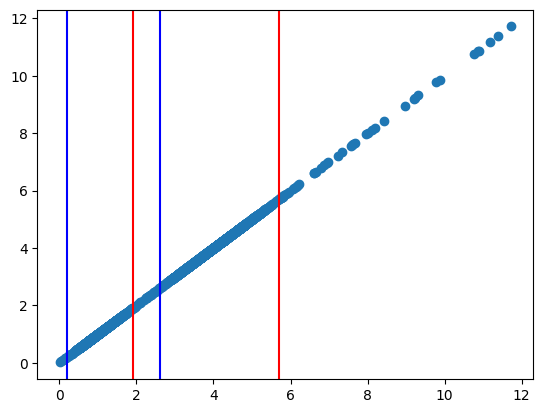

In [103]:
loss_sc = []
for i in loss_dist:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(upper_threshold1, 0.0, 1, color='r')
plt.axvline(lower_threshold1, 0.0, 1, color='b')
plt.axvline(upper_threshold2, 0.0, 1, color='r')
plt.axvline(lower_threshold2, 0.0, 1, color='b')

In [106]:
correct1 = sum(l < int(upper_threshold1) and l > int(lower_threshold1) for l in loss_dist)
correct2 = sum(l < int(upper_threshold2) and l > int(lower_threshold2) for l in loss_dist)

print(f'Correct normal predictions: {correct1 + correct2}/{len(X_made_test)}')

up_abnormal = sum(l >= int(upper_threshold2) for l in loss_dist)
middle_abnormal = sum(l >= int(upper_threshold1) and l <= int(lower_threshold2) for l in loss_dist)
down_abnormal = sum(l <= int(lower_threshold1) for l in loss_dist)

print(f'Correct anomaly predictions: {up_abnormal+middle_abnormal+down_abnormal}/{len(X_made_test)}')

Correct normal predictions: 2973/4200
Correct anomaly predictions: 1227/4200


In [107]:
tp, fp, tn, fn = 0, 0, 0, 0

for i in range(len(loss_dist)):
    a = X_made_test.iloc[i]
    a['loss'] = loss_dist[i]
    if a['loss'] >= upper_threshold2 or upper_threshold1 <= a['loss'] <= lower_threshold2 or a['loss'] <= lower_threshold1:
        if float(a['label']) == 1.0:
            tp += 1
        else:
            fp += 1
    else:
        if float(a['label']) == 1.0:
            fn += 1
        else:
            tn += 1
            
print('[TP] {}\t[FP] {}\n[TN] {}[FN] {}'.format(tp, fp, tn, fn))

[TP] 75	[FP] 15
[TN] 3985[FN] 125


In [108]:
def get_classifier_eval(tn=tn, fp=fp, fn=fn, tp=tp):
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (2*precision*recall)/(precision+recall)
    print(f'Accuracy:{accuracy:.4f}, Precision :{precision:.4f}, Recall:{recall:.4f}, F1-Score:{f1:.4f}')

Accuracy:0.9667, Precision :0.8333, Recall:0.3750, F1-Score:0.5172
[TP] 75	[FP] 15	[TN] 3985 [FN] 125


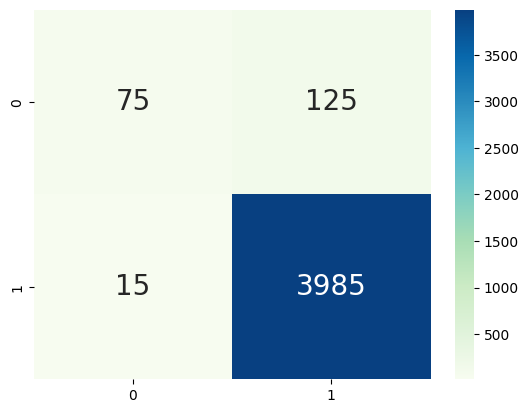

In [109]:
conf = [[tp,fn],[fp,tn]]
plt.figure()
sns.heatmap(conf, annot=True, annot_kws={"size": 20}, fmt='d', cmap='GnBu')
get_classifier_eval(tn, fp, fn, tp)
print('[TP] {}\t[FP] {}\t[TN] {} [FN] {}'.format(tp, fp, tn, fn))

MNIST 용도

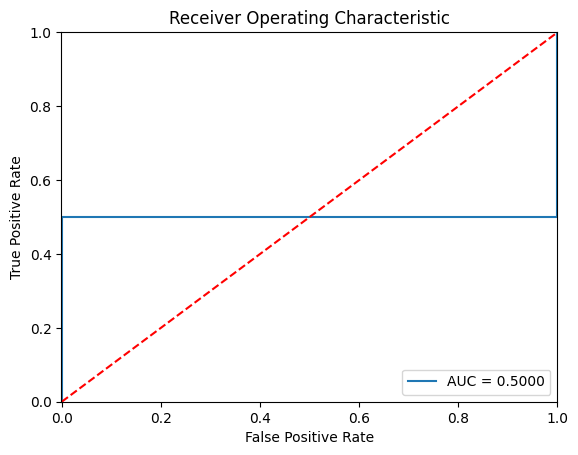

AUC:0.5


In [76]:
plot_ROC(X_mnist_test['label'].to_list(), loss_dist)

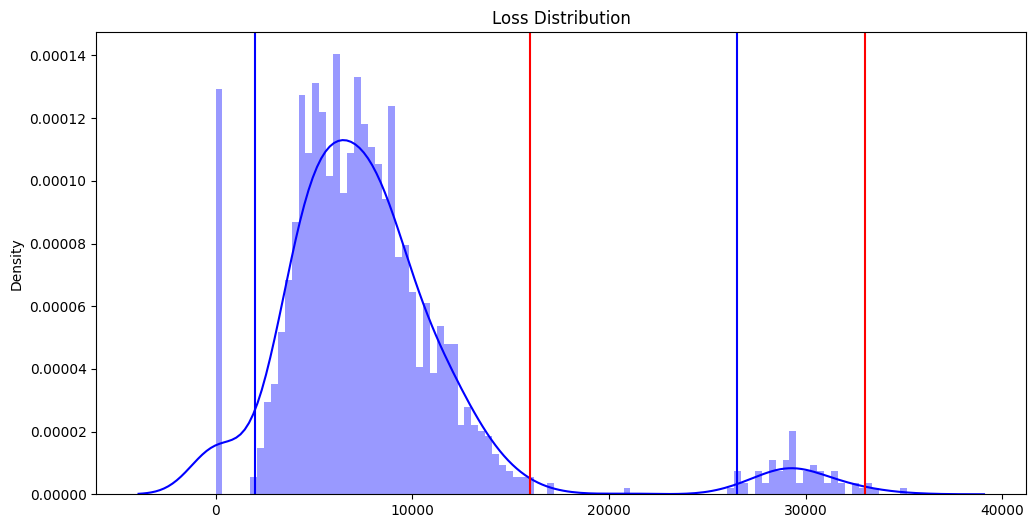

In [83]:
# Custom data 용

lower_threshold1 = 2000
upper_threshold1 = 16000
lower_threshold2 = 26500
upper_threshold2 = 33000

plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(loss_dist,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold1, 0.0, 1, color='r')
plt.axvline(lower_threshold1, 0.0, 1, color='b')
plt.axvline(upper_threshold2, 0.0, 1, color='r')
plt.axvline(lower_threshold2, 0.0, 1, color='b')

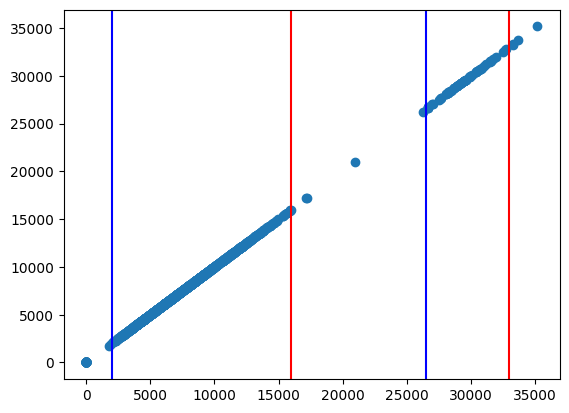

In [84]:
loss_sc = []
for i in loss_dist:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(upper_threshold1, 0.0, 1, color='r')
plt.axvline(lower_threshold1, 0.0, 1, color='b')
plt.axvline(upper_threshold2, 0.0, 1, color='r')
plt.axvline(lower_threshold2, 0.0, 1, color='b')

In [85]:
correct1 = sum(l < int(upper_threshold1) and l > int(lower_threshold1) for l in loss_dist)
correct2 = sum(l < int(upper_threshold2) and l > int(lower_threshold2) for l in loss_dist)

print(f'Correct normal predictions: {correct1 + correct2}/{len(X_mnist_test)}')

up_abnormal = sum(l >= int(upper_threshold2) for l in loss_dist)
middle_abnormal = sum(l >= int(upper_threshold1) and l <= int(lower_threshold2) for l in loss_dist)
down_abnormal = sum(l <= int(lower_threshold1) for l in loss_dist)

print(f'Correct anomaly predictions: {up_abnormal+middle_abnormal+down_abnormal}/{len(X_mnist_test)}')

Correct normal predictions: 1460/1540
Correct anomaly predictions: 80/1540


In [86]:
tp, fp, tn, fn = 0, 0, 0, 0

for i in range(len(loss_dist)):
    a = X_mnist_test.iloc[i]
    a['loss'] = loss_dist[i]
    if a['loss'] >= upper_threshold2 or upper_threshold1 <= a['loss'] <= lower_threshold2 or a['loss'] <= lower_threshold1:
        if float(a['label']) == 1.0:
            tp += 1
        else:
            fp += 1
    else:
        if float(a['label']) == 1.0:
            fn += 1
        else:
            tn += 1
            
print('[TP] {}\t[FP] {}\n[TN] {} [FN] {}'.format(tp, fp, tn, fn))

[TP] 75	[FP] 5
[TN] 1395 [FN] 65


In [87]:
def get_classifier_eval(tn=tn, fp=fp, fn=fn, tp=tp):
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (2*precision*recall)/(precision+recall)
    print(f'Accuracy:{accuracy:.4f}, Precision :{precision:.4f}, Recall:{recall:.4f}, F1-Score:{f1:.4f}')

Accuracy:0.9545, Precision :0.9375, Recall:0.5357, F1-Score:0.6818
[TP] 75	[FP] 5	[TN] 1395 [FN] 65


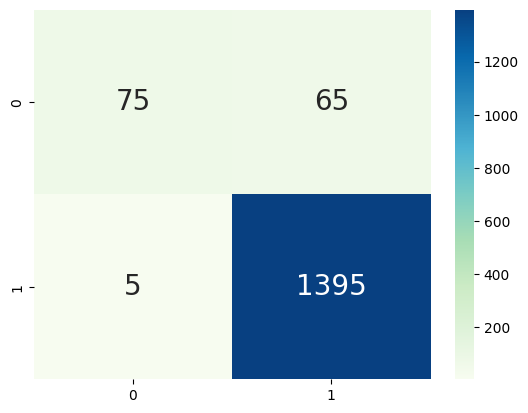

In [88]:
conf = [[tp,fn],[fp,tn]]
plt.figure()
sns.heatmap(conf, annot=True, annot_kws={"size": 20}, fmt='d', cmap='GnBu')
get_classifier_eval(tn, fp, fn, tp)
print('[TP] {}\t[FP] {}\t[TN] {} [FN] {}'.format(tp, fp, tn, fn))